# Recurrent Neural Network Model (LSTM Model)

## Model with 5 seperate linear layers
In this nb, I tried to **build a seperate linear layer for each parameter(output)**. Since then, the model has 5 linear layers and the data feed in will be unscaled.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [37]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Load h5 spectra and model parameters
import numpy as np
import pandas as pd
import os
import h5py
import tables
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import time
from IPython.display import Markdown, display

In [3]:
from pathlib import Path
PATH = Path("/mnt/wamri/brainlabs/lexie/spectrome-ai/data")

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Get Data
### Read from clean files

In [5]:
def parse_data(path: str):
    # load data from the disk
    data = np.load(PATH/path, allow_pickle=True)
    df = pd.DataFrame(data=data, index=data[:,0:5])
    df = df.drop([0, 1, 2, 3, 4], axis=1)
    df = df.reset_index()
    df.columns = ['params', 'freq']
    return df

In [6]:
train_df = parse_data('train.npy')

In [7]:
val_df = parse_data('val.npy')

In [8]:
train_df.head(3)

,params,freq
0,"(0.006774817007605203, 0.02009569890767441, 0....","[[(-0.5363079897402153+0.23131415988148957j), ..."
1,"(0.006665624695702036, 0.007136992805070295, 1...","[[(-0.8445742133913164-0.12417212129587563j), ..."
2,"(0.009857082118029867, 0.011149760592540766, 1...","[[(-0.16362021960862128-0.21202572414360818j),..."


### Dataset

In [11]:
class SPDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.x = np.abs(np.array(self.df['freq']))
        self.y = np.array(list(self.df['params']))

    def __len__(self):
        """ Length of the dataset """
        N, _ = self.df.shape
        return N

    def __getitem__(self, idx):
        """ returns x[idx], y[idx] for this dataset"""
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [12]:
train_ds = SPDataset(train_df)
valid_ds = SPDataset(val_df)

### DataLoader

In [13]:
train_dl = DataLoader(train_ds, batch_size=300, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=300)

## Model 
### parameter setting

In [14]:
input_size = 86
hidden_dim = 50
n_layers = 3
seq_len = 40
output_size = 5
batch_size = 300

In [15]:
# check if a GPU is available
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### model setting

In [16]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, seq_len, batch_size, drop_prob=0.5):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear1 = nn.Linear(hidden_dim, 1)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.linear4 = nn.Linear(hidden_dim, 1)
        self.linear5 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        lstm_out, (lstm_ht, lstm_ct) = self.lstm(x)
        lstm_ht[-1] = self.dropout(lstm_ht[-1])
        out1 = self.linear1(lstm_ht[-1])
        out2 = self.linear2(lstm_ht[-1])
        out3 = self.linear3(lstm_ht[-1])
        out4 = self.linear4(lstm_ht[-1])
        out5 = self.linear5(lstm_ht[-1])
        out = torch.cat([out1, out2, out3, out4, out5], 1)
        return out

In [17]:
model = LSTMNet(input_size, output_size, hidden_dim, n_layers, seq_len, batch_size)
model.to(device)

LSTMNet(
  (lstm): LSTM(86, 50, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (linear3): Linear(in_features=50, out_features=1, bias=True)
  (linear4): Linear(in_features=50, out_features=1, bias=True)
  (linear5): Linear(in_features=50, out_features=1, bias=True)
)

In [18]:
def R2_report(dataloader, model):
    y_pred = []
    y_all = []
    model.eval()
    for x, y in dataloader:
        y_all.append(y)
        x = torch.FloatTensor(x.float()).transpose(1,2).to(device)
        y = torch.FloatTensor(y.float()).to(device)
        out = model(x)
        y_pred.append(out.detach().cpu().numpy())

    y_pred = np.vstack(y_pred)
    y_all = np.vstack(y_all)
    r1 = r2_score(y_all[:,0], y_pred[:,0])
    r2 = r2_score(y_all[:,1], y_pred[:,1])
    r3 = r2_score(y_all[:,2], y_pred[:,2])
    r4 = r2_score(y_all[:,3], y_pred[:,3])
    r5 = r2_score(y_all[:,4], y_pred[:,4])
    return r1, r2, r3, r4, r5

In [19]:
def val_matrics(model):
    valid_losses = []
    model.eval()
    for x_val, y_val in valid_dl:
        x_valid = torch.FloatTensor(x_val.float()).transpose(1,2).to(device)
        y_valid = torch.FloatTensor(y_val.float()).to(device)
        out_valid = model(x_valid)
        valid_loss = criterion(out_valid, y_valid)
        valid_losses.append(valid_loss.item())
    return valid_losses

In [20]:
def training(model, optimizer, criterion, epochs=200):
    valid_loss_min = np.Inf
    for i in range(epochs):
        model.train()
        for x, y in train_dl:
            x = torch.FloatTensor(x.float()).transpose(1,2).to(device)
            y = torch.FloatTensor(y.float()).to(device)
            out = model(x)
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward(retain_graph=True)
            optimizer.step()
        val_losses = val_matrics(model)
        r1, r2, r3, r4, r5 =  R2_report(valid_dl, model)
        if np.mean(val_losses) <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print('saving model...')
        print("Epoch: {}/{}, ".format(i+1, epochs),
              "Train Loss: {:.4f}, ".format(loss.item()),
              "Val Loss: {:.4f}, ".format(np.mean(val_losses)),
              "R^2: {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(r1, r2, r3, r4, r5))
        valid_loss_min = np.mean(val_losses)

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
training(model, optimizer, criterion)

saving model...
Epoch: 1/200,  Train Loss: 1.2692,  Val Loss: 0.1758,  R^2: 0.1523, -0.0829, 0.6821, 0.9952, 0.0786
saving model...
Epoch: 2/200,  Train Loss: 1.1024,  Val Loss: 0.1675,  R^2: 0.1483, -0.0451, 0.6741, 0.9961, 0.0735
saving model...
Epoch: 3/200,  Train Loss: 1.0469,  Val Loss: 0.1641,  R^2: 0.1669, -0.0001, 0.6683, 0.9965, 0.0677
saving model...
Epoch: 4/200,  Train Loss: 1.4218,  Val Loss: 0.1630,  R^2: 0.1636, -0.0127, 0.6805, 0.9963, 0.0742
saving model...
Epoch: 5/200,  Train Loss: 1.0204,  Val Loss: 0.1571,  R^2: 0.1582, -0.0001, 0.6852, 0.9966, 0.0696
saving model...
Epoch: 6/200,  Train Loss: 0.9456,  Val Loss: 0.1564,  R^2: 0.1666, 0.0014, 0.6815, 0.9968, 0.0806
saving model...
Epoch: 7/200,  Train Loss: 1.1031,  Val Loss: 0.1538,  R^2: 0.1726, -0.0016, 0.6834, 0.9969, 0.0502
Epoch: 8/200,  Train Loss: 1.0411,  Val Loss: 0.1541,  R^2: 0.1525, -0.0054, 0.6866, 0.9968, 0.0473
Epoch: 9/200,  Train Loss: 0.8698,  Val Loss: 0.1553,  R^2: 0.1287, -0.0059, 0.6870, 0.99

## Plotting
### load the best model

In [62]:
bst_model = model.load_state_dict(torch.load('state_dict.pt'))

### Using test dataset

In [63]:
test_df = parse_data('test.npy')
test_ds = SPDataset(test_df)
test_dl = DataLoader(test_ds, batch_size=300)

In [64]:
 def test_model(dataloader, model):
    y_pred = []
    y_all = []
    for x, y in dataloader:
        y_all.append(y)
        x = torch.FloatTensor(x.float()).transpose(1,2).to(device)
        y = torch.FloatTensor(y.float()).to(device)
        out = model(x)
        y_pred.append(out.detach().cpu().numpy())

    y_pred = np.vstack(y_pred)
    y_all = np.vstack(y_all)
    r1 = r2_score(y_all[:,0], y_pred[:,0])
    r2 = r2_score(y_all[:,1], y_pred[:,1])
    r3 = r2_score(y_all[:,2], y_pred[:,2])
    r4 = r2_score(y_all[:,3], y_pred[:,3])
    r5 = r2_score(y_all[:,4], y_pred[:,4])
    return y_pred, y_all, [r1, r2, r3, r4, r5]

In [65]:
y_pred, y_all, r_2s = test_model(test_dl, model)

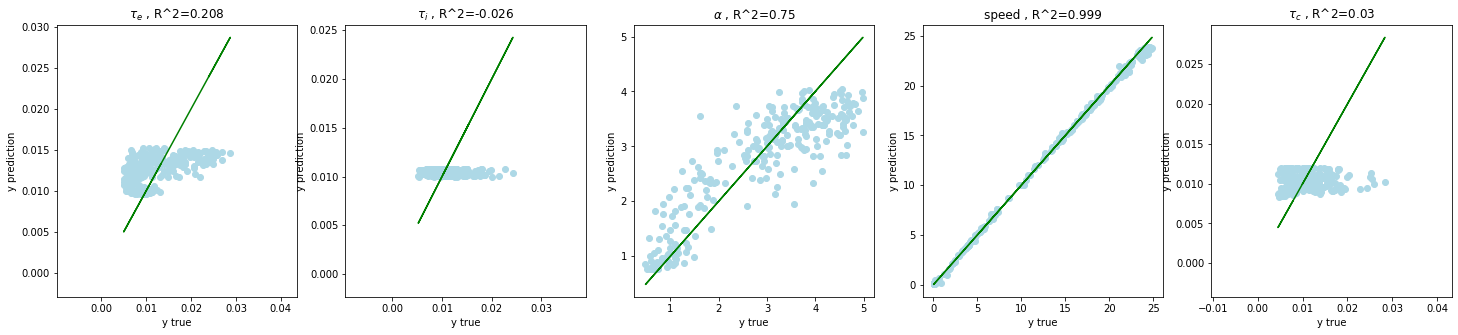

In [66]:
fig, axs = plt.subplots(1, 5, figsize=(25,5), sharex=False, sharey=False)
param_names = [r'$\tau_e$', r'$\tau_i$', r'$\alpha$', 'speed', r'$\tau_c$']

for i in range(5):
    axs[i].scatter(y_all[:, i], y_pred[:, i], color='lightblue')
    axs[i].plot(y_all[:, i], y_all[:, i], 'g')
    axs[i].title.set_text(param_names[i]+' , R^2='+str(round(r_2s[i], 3)))
    axs[i].set_xlabel('y true')
    axs[i].set_ylabel('y prediction')